<a href="https://colab.research.google.com/github/TarnaiMark/AdvStat/blob/main/halstat_survival.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercises

In [61]:
!pip install lifelines scikit-survival


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [62]:
import numpy as np
import pandas as pd
import lifelines as lf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

## 0.) Pre-processing

Load the <i><a href="https://scikit-survival.readthedocs.io/en/stable/api/generated/sksurv.datasets.load_veterans_lung_cancer.html">Veteran's Lung Cancer</a></i> dataset from <code>scikit-survival</code>! Note that it returns a <code>Pandas</code> DataFrame of the features, and a structured array containing the survival times, and censoring status.

In [63]:
from sksurv.datasets import load_veterans_lung_cancer
df,y = load_veterans_lung_cancer()
print(y.dtype)

[('Status', '?'), ('Survival_in_days', '<f8')]


Add the survival time and censoring status to the DataFrame as new columns!

In [64]:
df['survival_time'] = y['Survival_in_days']
df['censoring_status'] = y['Status']
df.head()

,Age_in_years,Celltype,Karnofsky_score,Months_from_Diagnosis,Prior_therapy,Treatment,survival_time,censoring_status
0,69.0,squamous,60.0,7.0,no,standard,72.0,True
1,64.0,squamous,70.0,5.0,yes,standard,411.0,True
2,38.0,squamous,60.0,3.0,no,standard,228.0,True
3,63.0,squamous,60.0,9.0,yes,standard,126.0,True
4,65.0,squamous,70.0,11.0,yes,standard,118.0,True


Take a look at the features! What kind of features do you see?

In [65]:
df.info()
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Age_in_years           137 non-null    float64 
 1   Celltype               137 non-null    category
 2   Karnofsky_score        137 non-null    float64 
 3   Months_from_Diagnosis  137 non-null    float64 
 4   Prior_therapy          137 non-null    category
 5   Treatment              137 non-null    category
 6   survival_time          137 non-null    float64 
 7   censoring_status       137 non-null    bool    
dtypes: bool(1), category(3), float64(4)
memory usage: 5.4 KB


,Age_in_years,Celltype,Karnofsky_score,Months_from_Diagnosis,Prior_therapy,Treatment,survival_time,censoring_status
count,137.000000,137,137.000000,137.000000,137,137,137.000000,137
unique,NaN,4,NaN,NaN,2,2,NaN,2
top,NaN,smallcell,NaN,NaN,no,standard,NaN,True
freq,NaN,48,NaN,NaN,97,69,NaN,128
mean,58.306569,NaN,58.569343,8.773723,NaN,NaN,121.627737,NaN
std,10.541628,NaN,20.039592,10.612141,NaN,NaN,157.816722,NaN
min,34.000000,NaN,10.000000,1.000000,NaN,NaN,1.000000,NaN
25%,51.000000,NaN,40.000000,3.000000,NaN,NaN,25.000000,NaN
50%,62.000000,NaN,60.000000,5.000000,NaN,NaN,80.000000,NaN
75%,66.000000,NaN,75.000000,11.000000,NaN,NaN,144.000000,NaN


Use one-hot-encoding on the categorical features!

Hint: [<code>pd.get_dummies(drop_first=True)</code>](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html)

In [66]:
df_encoded = pd.get_dummies(df, drop_first=True)
df_encoded.head()

,Age_in_years,Karnofsky_score,Months_from_Diagnosis,survival_time,censoring_status,Celltype_large,Celltype_smallcell,Celltype_squamous,Prior_therapy_yes,Treatment_test
0,69.0,60.0,7.0,72.0,True,False,False,True,False,False
1,64.0,70.0,5.0,411.0,True,False,False,True,True,False
2,38.0,60.0,3.0,228.0,True,False,False,True,False,False
3,63.0,60.0,9.0,126.0,True,False,False,True,True,False
4,65.0,70.0,11.0,118.0,True,False,False,True,True,False


Scale the the numeric features (except for the survival time) to have zero mean and unit variance!

Hint: [`sklearn.preprocessing.scale`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html)

In [67]:
from sklearn.preprocessing import scale
numeric_features = df_encoded.select_dtypes(include=['float64', 'int64']).drop(columns=['survival_time'])
scaled_features = scale(numeric_features)
df_scaled = pd.DataFrame(scaled_features, columns=numeric_features.columns)
df_scaled['survival_time'] = df_encoded['survival_time']
df_scaled['censoring_status'] = df_encoded['censoring_status']
df_scaled.head()

,Age_in_years,Karnofsky_score,Months_from_Diagnosis,survival_time,censoring_status
0,1.018123,0.071654,-0.167754,72.0,True
1,0.542072,0.572497,-0.356909,411.0,True
2,-1.933391,0.071654,-0.546064,228.0,True
3,0.446862,0.071654,0.021401,126.0,True
4,0.637282,0.572497,0.210556,118.0,True


## 1.) Kaplan-Meier estimator

Stratify the population according to some rule! This could be based on categories or numerical features. Calculate the Kaplan-Meier estimator (<code style="font-size:9px;"><a href="https://lifelines.readthedocs.io/en/latest/fitters/univariate/KaplanMeierFitter.html">lifelines.fitters.kaplan_meier_fitter.KaplanMeierFitter</a></code>) for each group and plot the results. Do the plots seem to show any differences?

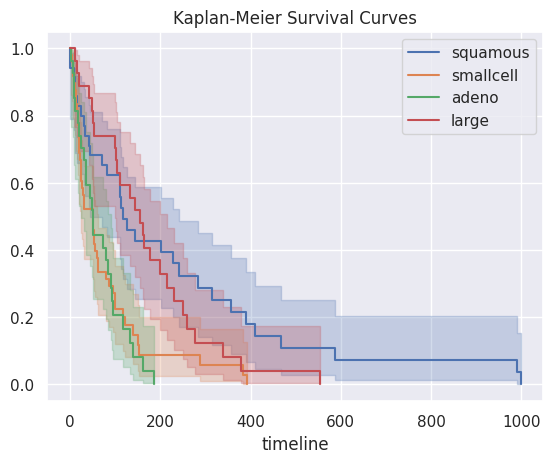

In [68]:
from lifelines import KaplanMeierFitter

# Stratify by a categorical feature (e.g., 'Celltype')
groups = df['Celltype']
kmf = KaplanMeierFitter()

for group in groups.unique():
    mask = groups == group
    kmf.fit(df['survival_time'][mask], event_observed=df['censoring_status'][mask], label=str(group))
    kmf.plot_survival_function()
plt.title("Kaplan-Meier Survival Curves")
plt.show()

Perform a logrank test to see whether these splits are meaningful. You can use <code style="font-size:9px;"><a href="https://lifelines.readthedocs.io/en/latest/lifelines.statistics.html#lifelines.statistics.logrank_test">lifelines.statistics.logrank_test</a></code>.





In [69]:
from lifelines.statistics import logrank_test

group1 = df['survival_time'][df['Celltype'] == 'squamous']
group2 = df['survival_time'][df['Celltype'] == 'adeno']
event1 = df['censoring_status'][df['Celltype'] == 'squamous']
event2 = df['censoring_status'][df['Celltype'] == 'adeno']

results = logrank_test(group1, group2, event_observed_A=event1, event_observed_B=event2)
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          12.05 <0.005     10.91

Heed the advice in the lifelines docs and repeat the testing with likelihood ratio test. Are the splits still meaningful? Fit a Cox proportional hazards model on a binary indicator of group membership. If the corresponding coefficient is confirmed by the likelihood ratio test to be non-zero, that means the grouping is meaningful.

In [70]:
from lifelines import CoxPHFitter

# Hozzunk létre egy bináris indikátor változót: 1 ha 'squamous', 0 ha 'adeno'
df_lr = df[df['Celltype'].isin(['squamous', 'adeno'])].copy()
df_lr['is_squamous'] = (df_lr['Celltype'] == 'squamous').astype(int)

# Cox modell illesztése csak az indikátor változóval
cph = CoxPHFitter()
cph.fit(df_lr[['survival_time', 'censoring_status', 'is_squamous']], 
        duration_col='survival_time', event_col='censoring_status')
cph.print_summary()  # Itt látható a likelihood ratio test eredménye is

<lifelines.CoxPHFitter: fitted with 62 total observations, 5 right-censored observations>
             duration col = 'survival_time'
                event col = 'censoring_status'
      baseline estimation = breslow
   number of observations = 62
number of events observed = 57
   partial log-likelihood = -174.94
         time fit was run = 2025-05-16 16:54:16 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
is_squamous -1.04      0.35      0.31           -1.65           -0.43                0.19                0.65

             cmp to     z      p  -log2(p)
covariate                                 
is_squamous    0.00 -3.34 <0.005     10.20
---
Concordance = 0.59
Partial AIC = 351.88
log-likelihood ratio test = 11.32 on 1 df
-log2(p) of ll-ratio test = 10.35

p érték: <0.005, tehát a különbség statisztikailag szignifikáns.
log-likelihood ratio test: 11.32 1 szabadságfokkal, amihez nagyon alacsony p-érték tartozik (lásd: -log2(p) = 10.35), tehát a modell szignifikánsan jobb, ha figyelembe vesszük a csoporttagságot.

## 2.)The Cox Proportional Hazards Model

Fit the [Cox proportional hazards model](https://lifelines.readthedocs.io/en/latest/fitters/regression/CoxPHFitter.html) to the preprocessed dataset! Plot the weights! According to them, which feature is the most influential?"

<lifelines.CoxPHFitter: fitted with 137 total observations, 9 right-censored observations>
             duration col = 'survival_time'
                event col = 'censoring_status'
      baseline estimation = breslow
   number of observations = 137
number of events observed = 128
   partial log-likelihood = -484.39
         time fit was run = 2025-05-16 16:54:16 UTC

---
                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                              
Age_in_years          -0.02      0.98      0.10           -0.21            0.16                0.81                1.18
Karnofsky_score       -0.67      0.51      0.10           -0.88           -0.47                0.42                0.63
Months_from_Diagnosis  0.01      1.01      0.09           -0.17            0.19                0.85                1.20

                       cmp to     z      p  -log2(p)
covariate                                           
Age_in_years             0.00 -0.25   0.80      0.32
Karnofsky_score          0.00 -6.43 <0.005     32.87
Months_from_Diagnosis    0.00  0.11   0.92      0.13
---
Concordance = 0.71
Partial AIC = 974.79
log-likelihood ratio test = 42.11 on 3 df
-log2(p) of ll-ratio test = 27.97

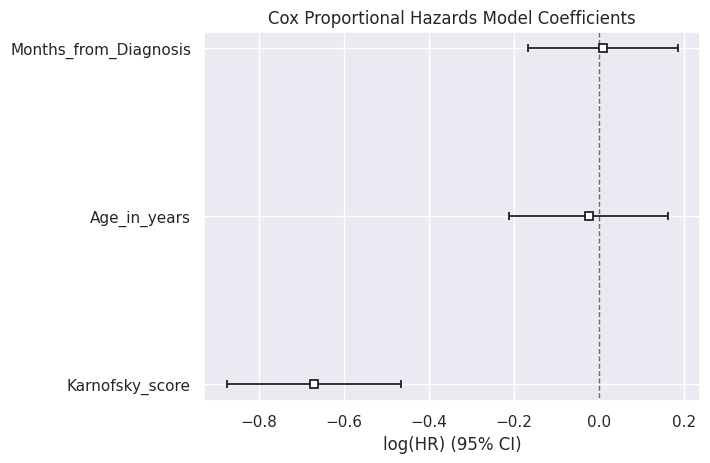

In [71]:
# Fit the Cox Proportional Hazards Model to the preprocessed dataset
cph = CoxPHFitter()
cph.fit(df_scaled, duration_col='survival_time', event_col='censoring_status')
cph.print_summary()

# Plot the coefficients (weights)
cph.plot()
plt.title("Cox Proportional Hazards Model Coefficients")
plt.show()

Is there any feature where the hypothesis for a zero coefficient cannot be discarded? Look at the Wald-test results!

In [72]:


# Ha az összes Wald-teszt statisztikát szeretnéd:
print("\nWald-teszt statisztikák:")
print(cph.summary[['coef', 'se(coef)', 'z', 'p']])


Wald-teszt statisztikák:
                           coef  se(coef)         z             p
covariate                                                        
Age_in_years          -0.024216  0.095793 -0.252800  8.004225e-01
Karnofsky_score       -0.671799  0.104481 -6.429884  1.277011e-10
Months_from_Diagnosis  0.009449  0.089707  0.105332  9.161123e-01


Could these results be due to the data having some time-varying effect? Check the assumptions by using a 95% confidence interval and plotting the scaled Schoenfeld residuals!


   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 137 total observations, 9 right-censored observations>
         test_name = proportional_hazard_test

---
                            test_statistic      p  -log2(p)
Age_in_years          km              4.81   0.03      5.14
                      rank            4.96   0.03      5.27
Karnofsky_score       km             14.89 <0.005     13.10
                      rank           15.36 <0.005     13.45
Months_from_Diagnosis km              0.38   0.54      0.90
                      rank            0.31   0.58      0.80



1. Variable 'Age_in_years' failed the non-proportional test: p-value is 0.0260.

   Advice 1: the functional form of the variable 'Age_in_years' might be incorrect. That is, there
may be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'Age_in_years' using pd.cut, and then specify it in
`strata=['Age_in_years', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


2. Variable 'Karnofsky_score' failed the non-proportional test: p-value is 0.0001.

   Advice 1: the functional form of the variable 'Karnofsky_score' might be incorrect. That is,
there may be non-linear terms missing. The proportional hazard test used is very sensitive to
incorrect 

[[<Axes: xlabel='rank-transformed time\n(p=0.0260)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0283)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0001)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0001)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.5761)'>,
  <Axes: xlabel='km-transformed time\n(p=0.5351)'>]]

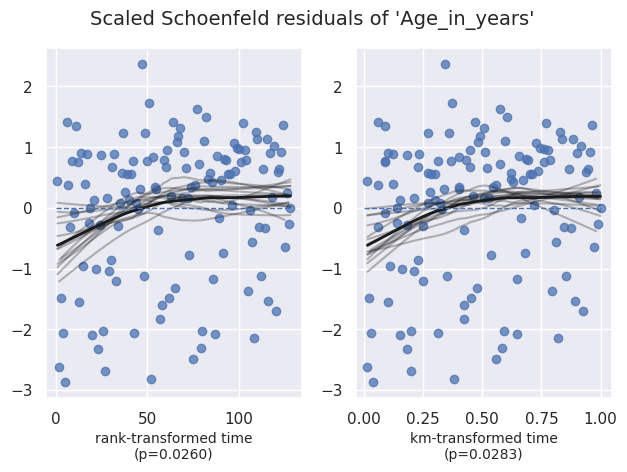

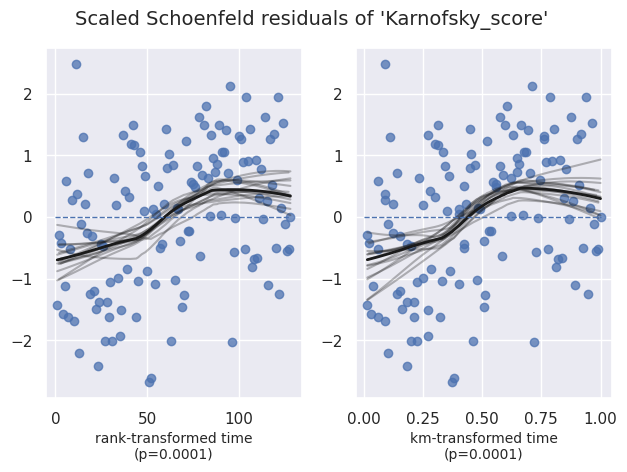

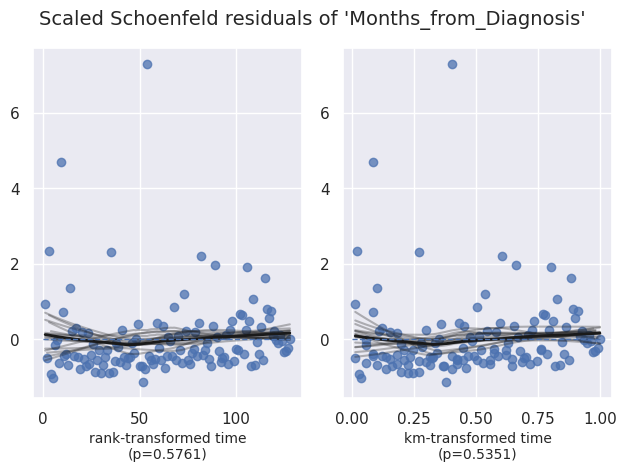

In [73]:
# Check the proportional hazards assumption and plot Schoenfeld residuals
cph.check_assumptions(df_scaled, p_value_threshold=0.05, show_plots=True)

Heed **Advice 2** and stratify the model. After stratification, each stratum will have its own CPH model that will hopefully satisfy the proportional hazards assumption.

Hint: Use [`pd.qcut`](https://pandas.pydata.org/docs/reference/api/pandas.qcut.html) to bin any numeric features according to the median (2-quantile).

Stratified Cox Model Summary:


/usr/local/python/3.12.1/lib/python3.12/site-packages/lifelines/fitters/__init__.py:1280: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, df_ in df.groupby(strata):
/usr/local/python/3.12.1/lib/python3.12/site-packages/lifelines/fitters/coxph_fitter.py:1868: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, stratified_X in X.groupby(self.strata):
/usr/local/python/3.12.1/lib/python3.12/site-packages/lifelines/fitters/coxph_fitter.py:1868: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain curre

<lifelines.CoxPHFitter: fitted with 137 total observations, 9 right-censored observations>
             duration col = 'survival_time'
                event col = 'censoring_status'
                   strata = karnofsky_group
      baseline estimation = breslow
   number of observations = 137
number of events observed = 128
   partial log-likelihood = -410.66
         time fit was run = 2025-05-16 16:54:44 UTC

---
                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                              
Age_in_years          -0.04      0.96      0.10           -0.23            0.15                0.79                1.16
Karnofsky_score       -0.72      0.48      0.16           -1.04           -0.40                0.35                0.67
Months_from_Diagnosis -0.01      0.99      0.09           -0.18            0.16                0.84                1.18

                       cmp to     z      p  -log2(p)
covariate                                           
Age_in_years             0.00 -0.43   0.66      0.59
Karnofsky_score          0.00 -4.44 <0.005     16.75
Months_from_Diagnosis    0.00 -0.06   0.95      0.07
---
Concordance = 0.63
Partial AIC = 827.32
log-likelihood ratio test = 19.43 on 3 df
-log2(p) of ll-ratio test = 12.13

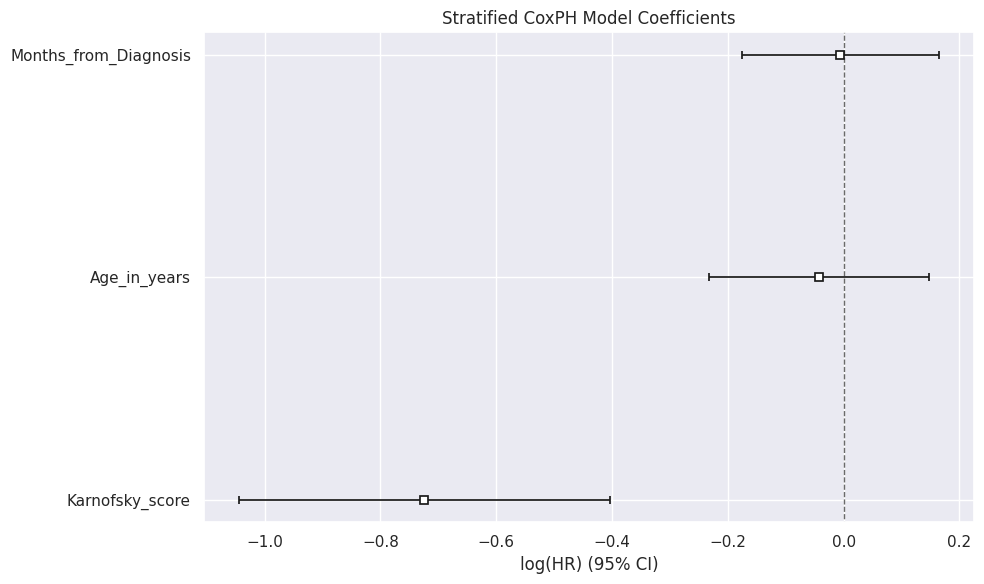


Verifying Stratification with Kaplan-Meier:


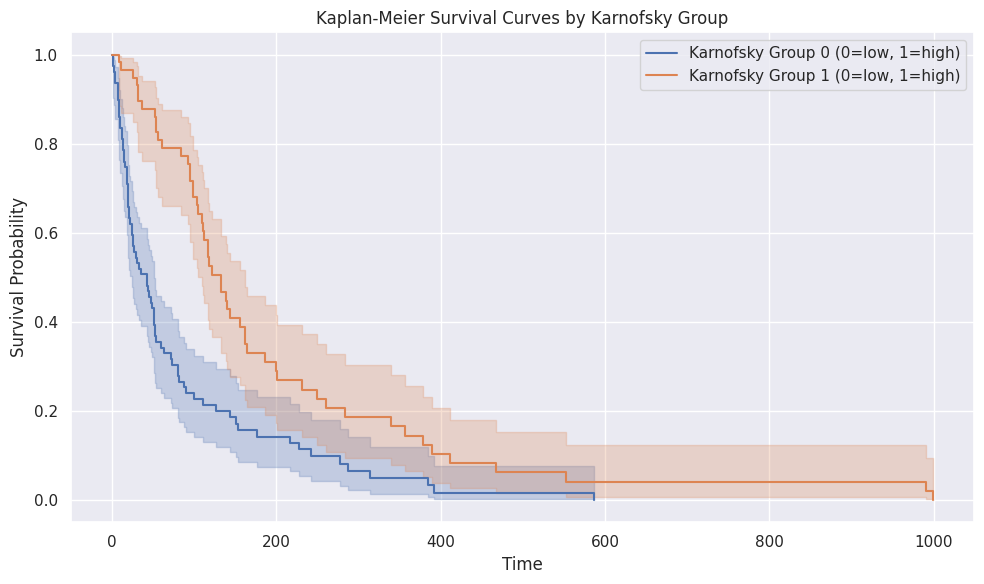


Group Mapping: {0: 'Low Karnofsky', 1: 'High Karnofsky'}


In [75]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter, KaplanMeierFitter
import matplotlib.pyplot as plt

# 1. Create stratified groups (median split with numeric codes)
df_scaled_sep = df_scaled.copy()
df_scaled_sep['karnofsky_group'] = pd.qcut(
    df['Karnofsky_score'],
    q=2,
    labels=[0, 1]  # Using numeric codes instead of strings
)

# 2. Fit stratified Cox model
cph_strat = CoxPHFitter()
cph_strat.fit(
    df_scaled_sep,
    duration_col='survival_time',
    event_col='censoring_status',
    strata=['karnofsky_group']  # Stratify by the numeric group
)

# 3. Print model summary
print("Stratified Cox Model Summary:")
cph_strat.print_summary()

# 4. Plot coefficients
plt.figure(figsize=(10, 6))
cph_strat.plot()
plt.title("Stratified CoxPH Model Coefficients")
plt.tight_layout()
plt.show()

# 5. Verify stratification with Kaplan-Meier plots
print("\nVerifying Stratification with Kaplan-Meier:")
plt.figure(figsize=(10, 6))
kmf = KaplanMeierFitter()

for group in [0, 1]:
    mask = df_scaled_sep['karnofsky_group'] == group
    kmf.fit(
        durations=df_scaled[mask]['survival_time'],
        event_observed=df_scaled[mask]['censoring_status'],
        label=f"Karnofsky Group {group} (0=low, 1=high)"
    )
    kmf.plot_survival_function()

plt.title("Kaplan-Meier Survival Curves by Karnofsky Group")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Add interpretation mapping
group_mapping = {0: "Low Karnofsky", 1: "High Karnofsky"}
print(f"\nGroup Mapping: {group_mapping}")


## 3.) Concordance index
Unfortunetly Uno's IPC-weighted c-index is not implemented in lifelines, so we have to use the [scikit-survival implementation](https://scikit-survival.readthedocs.io/en/stable/api/generated/sksurv.metrics.concordance_index_ipcw.html). This also requires [`sksurv.utils.Surv`](https://scikit-survival.readthedocs.io/en/stable/api/generated/sksurv.util.Surv.html) to create the structured arrays, which are then passed on to the metric.

Calculate the c-index, for various truncation times in a 5-fold cross-validation scheme for both the stratified and unstratified models! What do you observe?

In [81]:
import numpy as np
from sklearn.model_selection import KFold
from sksurv.util import Surv
from sksurv.metrics import concordance_index_ipcw
from lifelines import CoxPHFitter

# Configuration
N_FOLDS = 5
TRUNCATION_TIMES = np.quantile(df['survival_time'], [0.5, 0.75, 0.9])  # 50th, 75th, 90th percentiles

# Initialize results storage
results = {
    'unstratified': {t: [] for t in TRUNCATION_TIMES},
    'stratified': {t: [] for t in TRUNCATION_TIMES}
}

# 5-fold CV
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)
for train_idx, test_idx in kf.split(df_scaled):
    df_train, df_test = df_scaled.iloc[train_idx].copy(), df_scaled.iloc[test_idx].copy()
    
    # Prepare survival data
    y_train = Surv.from_arrays(event=df_train['censoring_status'].astype(bool), 
                              time=df_train['survival_time'])
    y_test = Surv.from_arrays(event=df_test['censoring_status'].astype(bool), 
                             time=df_test['survival_time'])
    
    # --- Unstratified Model ---
    cph = CoxPHFitter()
    cph.fit(df_train, duration_col='survival_time', event_col='censoring_status')
    risk_scores = cph.predict_partial_hazard(df_test)
    
    for tau in TRUNCATION_TIMES:
        uno_c = concordance_index_ipcw(y_train, y_test, risk_scores, tau=tau)
        results['unstratified'][tau].append(uno_c[0])
    
    # --- Stratified Model ---
    # Recreate stratification on the original (unscaled) Karnofsky_score
    karnofsky_train = df.iloc[train_idx]['Karnofsky_score']
    karnofsky_test = df.iloc[test_idx]['Karnofsky_score']
    df_train['karnofsky_group'] = pd.qcut(karnofsky_train, q=2, labels=[0,1])
    df_test['karnofsky_group'] = pd.qcut(karnofsky_test, q=2, labels=[0,1])
    
    cph_strat = CoxPHFitter()
    cph_strat.fit(df_train, duration_col='survival_time', event_col='censoring_status', 
                 strata=['karnofsky_group'])
    risk_scores_strat = cph_strat.predict_partial_hazard(df_test)
    
    for tau in TRUNCATION_TIMES:
        uno_c = concordance_index_ipcw(y_train, y_test, risk_scores_strat, tau=tau)
        results['stratified'][tau].append(uno_c[0])

# Analyze results
print("Cross-validated C-index (Uno's):")
for tau in TRUNCATION_TIMES:
    print(f"\nAt {tau:.1f} time units:")
    print(f"Unstratified: {np.mean(results['unstratified'][tau]):.3f} ± {np.std(results['unstratified'][tau]):.3f}")
    print(f"Stratified:   {np.mean(results['stratified'][tau]):.3f} ± {np.std(results['stratified'][tau]):.3f}")

/usr/local/python/3.12.1/lib/python3.12/site-packages/lifelines/fitters/__init__.py:1280: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, df_ in df.groupby(strata):
/usr/local/python/3.12.1/lib/python3.12/site-packages/lifelines/fitters/coxph_fitter.py:1868: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for stratum, stratified_X in X.groupby(self.strata):
/usr/local/python/3.12.1/lib/python3.12/site-packages/lifelines/fitters/coxph_fitter.py:1868: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain curre

Cross-validated C-index (Uno's):

At 80.0 time units:
Unstratified: 0.750 ± 0.038
Stratified:   0.754 ± 0.035

At 144.0 time units:
Unstratified: 0.698 ± 0.063
Stratified:   0.704 ± 0.060

At 284.6 time units:
Unstratified: 0.689 ± 0.060
Stratified:   0.694 ± 0.056


What do you think are the reasons for the results?